# Semester 1 Project Submission

Please fill out:
* Student name: Cristian González Ramírez
* Instructor name: Nick McCarty & Julian Ward

# This notebook tries to answer to the following question:

*How are the production budgets for movies based on their genre in comparison to their income? Would it be profitable?*

For this question specifically, we are interested on knowing the Production Costs, the Total Gross (both domestic and foreign) and the Genres of each movie. This information can be easily foundin the following dataframes and tables:
* `movie_budgets`
* `SQL im.db"`

## Retreiving and cleaning data up

### Importing libraries
We will start by adding the basic libraries to our notebook, so it runs nice and smoothly.

In [1302]:
# Import all libraries the project will requiere

#For retreiving data
import pandas as pd
import sqlite3
import zipfile

#For analyzing data
from scipy import stats

#For plotting and visulaizations
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

### Retreiving general information
Then, we insert the data we will be working with.

In [1303]:
#Retrieving data to work with
movie_budgets    = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

#The following lines import data that won't be use throughout the project.

#movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
#movies           = pd.read_csv("zippedData/tmdb.movies.csv.gz")
#movie_info_data  = pd.read_csv("zippedData/rt.movie_info.tsv.gz", sep="\t")

In [1304]:
#Oppening SQLite3 zip
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

conn = sqlite3.connect("im.db")

### Cleaning Movie Budgets data

Before starting any anylisis at all, we have to be sure that the data we are dealing with is ready to be manipulated. In order to accopmlish that, we must clean the data from all the tables using diffent data cleaning techniques.

First we will start with `movie_budget`.

In [1305]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [1306]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


As we see all of the values are a `Not-Null`, so most of the job is done; even so that is not the end of it, there are still a few considerations that must be taken.

Here we check if there is any movie appearing more than once.

In [1307]:
print(len(movie_budgets.movie.unique()), movie_budgets.shape[0])

5698 5782


Since these two numbers differ, we must take a look into it and remove any duplicates if any.

In [1308]:
movie_budgets.movie.value_counts()

Halloween                         3
Home                              3
King Kong                         3
Hercules                          2
The Island                        2
                                 ..
Hitman: Agent 47                  1
Deuce Bigalow: Male Gigolo        1
Molly                             1
Walk Hard: The Dewey Cox Story    1
The Painted Veil                  1
Name: movie, Length: 5698, dtype: int64

In fact, we have a bunch of repeating movies. We have to deal with them, so they only appear once.

In [1309]:
movie_budgets.drop_duplicates(subset=["movie"], inplace=True)

In [1310]:
print(len(movie_budgets.movie.unique()), movie_budgets.shape[0])

5698 5698


Now both values are similiar, which let us know that we got rid of duplicates perfectly.

When we ran the `.info()` command above, we also have found that `production_budget`, `domestic_gross` and `worldwide_gross` are object types, when we need them to be a numeric value, to perform further comparisons. So we have to take care of that issue too.

In [1311]:
#Getting rid off commas so it can be casted
movie_budgets.production_budget.replace(",","",regex=True, inplace=True)
movie_budgets.domestic_gross.replace(",","",regex=True, inplace=True)
movie_budgets.worldwide_gross.replace(",","",regex=True, inplace=True)

#Getting rid off $
movie_budgets["production_budget"] = movie_budgets.production_budget.str.strip("$")
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.str.strip("$")
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.str.strip("$")

In [1312]:
#Casting grosses as a floats
movie_budgets["production_budget"] = movie_budgets.production_budget.astype(float)
movie_budgets["domestic_gross"] = movie_budgets.domestic_gross.astype(float)
movie_budgets["worldwide_gross"] = movie_budgets.worldwide_gross.astype(float)

In [1313]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


It could be useful to have a `profit_or_loss` column for easier analysis later.

In [1314]:
movie_budgets["profit_or_loss"] = movie_budgets.worldwide_gross - movie_budgets.production_budget

A `relation_pro_los` column to visualize easily in percentage how does income related to budget could also be benefitial later on.

In [1315]:
movie_budgets["relation_pro_los"] = movie_budgets.worldwide_gross/movie_budgets.production_budget

In [1316]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,4.153696


### Retreiving Movie Ratings data
Now we get the info from the relevant SQL table for the analysis.

In [1317]:
#Obtain relevant information from SQL database
query = '''
    SELECT
        movie_id AS "ID",
        primary_title AS "Title",
        original_title AS "Original Title",
        genres AS "Genres"
    FROM movie_basics
        JOIN movie_ratings
        USING (movie_id)
'''

#Assign the query to a pandas dataframe
movie_by_genre = pd.read_sql(query,conn)

In [1318]:
movie_by_genre.head(10)

,ID,Title,Original Title,Genres
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy"
5,tt0112502,Bigfoot,Bigfoot,"Horror,Thriller"
6,tt0137204,Joe Finds Grace,Joe Finds Grace,"Adventure,Animation,Comedy"
7,tt0146592,Pál Adrienn,Pál Adrienn,Drama
8,tt0154039,So Much for Justice!,Oda az igazság,History
9,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,Documentary


### Cleaning SQL data

In [1319]:
movie_by_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              73856 non-null  object
 1   Title           73856 non-null  object
 2   Original Title  73856 non-null  object
 3   Genres          73052 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


We see that most of the data we obtained is mostly complete, having a few null-values in the `Genres` column, since that is the primary variable we are focusing on, the better way to approach this issue would be to simply drop those rows, but we will do that at the very end of the clean up.

We start taking care of some small values that could mess up our analysis.

We check and drop duplicates (if any) as before.

In [1320]:
print(len(movie_by_genre.Title.unique()), movie_by_genre.shape[0])

69993 73856


In [1321]:
movie_by_genre.Title.value_counts()

The Return                    11
Broken                        10
Lucky                          9
Homecoming                     9
Together                       9
                              ..
Venise n'est pas en Italie     1
Becks letzter Sommer           1
Honey Bee 2: Celebrations      1
Jewel's Catch One              1
Alright Now                    1
Name: Title, Length: 69993, dtype: int64

In [1322]:
movie_by_genre.drop_duplicates(subset=["Title"], inplace=True)

In [1323]:
print(len(movie_by_genre.Title.unique()), movie_by_genre.shape[0])

69993 69993


In [1324]:
print(len(movie_by_genre["Original Title"].unique()), movie_by_genre["Original Title"].shape[0])

69820 69993


In [1325]:
movie_by_genre["Original Title"].value_counts()

Missed Connections                        3
Un Français                               2
The Horror                                2
Stripped                                  2
Brooklyn                                  2
                                         ..
Miracle on 42nd Street                    1
Suhada Koka                               1
I Am Going to Kill Someone This Friday    1
Hangi Film                                1
Red Riding Hood                           1
Name: Original Title, Length: 69820, dtype: int64

In [1326]:
movie_by_genre.drop_duplicates(subset=["Original Title"], inplace = True)

In [1327]:
print(len(movie_by_genre["Original Title"].unique()), movie_by_genre["Original Title"].shape[0])

69820 69820


We also check that every ID is unique.

In [1328]:
movie_by_genre.ID.value_counts().sort_values(ascending = True)

tt5654204    1
tt6788646    1
tt7629994    1
tt1848975    1
tt5834808    1
            ..
tt3811012    1
tt4469842    1
tt1542045    1
tt1617000    1
tt5628792    1
Name: ID, Length: 69820, dtype: int64

And they are! There is no problem in the ID column. 

Now, most of the cleaning of this Dataframe is done. The next step to do is to decide how to procede with the missing values we saw in the Genres column. There are around 800 missing values, and dropping those columns won't represent as much of a loss, so we will proceed with this approach, since we will still have a significant population for analysis.

In [1329]:
movie_by_genre = movie_by_genre[movie_by_genre.Genres.str.contains("None") == False]

In [1330]:
movie_by_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69059 entries, 0 to 73852
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              69059 non-null  object
 1   Title           69059 non-null  object
 2   Original Title  69059 non-null  object
 3   Genres          69059 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB


We can see we have a dataframe without any null value or duplicates. We can consider this dataframe to be clean!

In [1331]:
movie_by_genre.head()

,ID,Title,Original Title,Genres
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy"


### Merging tables
Now, we shall proceed with joining the `movie_rating` dataframe with the `movie_budgets` one to proceed with the analysis. In this approach, we are using the `.merge()` method instead of `.join()` because we actually want information from both of the dataframes

In [1332]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,4.153696


In [1333]:
#Create a new Dataframe to store the merge
gross_and_genre = pd.merge(movie_budgets, movie_by_genre, how="inner", left_on="movie", right_on="Title")

In [1334]:
gross_and_genre.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los,ID,Title,Original Title,Genres
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577,tt1775309,Avatar,Abatâ,Horror
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892,tt6565702,Dark Phoenix,Dark Phoenix,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.748134e+09,6.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,"Action,Adventure,Sci-Fi"


Now we just do some visual cleaning.

In [1335]:
#Deleting duplicated columns
del gross_and_genre["Title"]
del gross_and_genre["Original Title"]
del gross_and_genre["id"]

#Deleting columns that are not relevant to the analysis
del gross_and_genre["release_date"]

In [1336]:
#Rearenging columns for easier lecture
gross_and_genre = gross_and_genre[["ID", "movie", "Genres","production_budget", 
                                     "domestic_gross", "worldwide_gross",
                                     "profit_or_loss", "relation_pro_los"]]

In [1337]:
gross_and_genre.columns

Index(['ID', 'movie', 'Genres', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'profit_or_loss', 'relation_pro_los'],
      dtype='object')

One last check to see if everything is in order.

In [1338]:
gross_and_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 0 to 2110
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 2111 non-null   object 
 1   movie              2111 non-null   object 
 2   Genres             2111 non-null   object 
 3   production_budget  2111 non-null   float64
 4   domestic_gross     2111 non-null   float64
 5   worldwide_gross    2111 non-null   float64
 6   profit_or_loss     2111 non-null   float64
 7   relation_pro_los   2111 non-null   float64
dtypes: float64(5), object(3)
memory usage: 148.4+ KB


And it is indeed.

In [1339]:
gross_and_genre.head()

,ID,movie,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,tt1775309,Avatar,Horror,425000000.0,760507625.0,2.776345e+09,2.351345e+09,6.532577
1,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",410600000.0,241063875.0,1.045664e+09,6.350639e+08,2.546673
2,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",350000000.0,42762350.0,1.497624e+08,-2.002376e+08,0.427892
3,tt2395427,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",330600000.0,459005868.0,1.403014e+09,1.072414e+09,4.243841
4,tt4154756,Avengers: Infinity War,"Action,Adventure,Sci-Fi",300000000.0,678815482.0,2.048134e+09,1.748134e+09,6.827114


Finally, after getting all of our interest values together, the next step would be to jump into analysis, in which we compare the income of a movie based on its genre with the production budget it had.

## Performing visual analysis

Let us recall the question we are trying to solve:

*"How are the production budgets for movies based on their genre in comparison to their income? Would it be profitable?"*

Therefore, we have to compare every income of every genre, but as we can see, there are many movies that share genres, which may represent a problem while comparing them. Getting appart every genre into an individual one is out of the scope of this project, so each group of genres will be considered as an individual one and proceed with the analysis as they are. There is no major problem in this, because, as we will see, there are times in which a specific group of genres is more profitable than other and even to its no-groupped counterpart.

We organize the information to be easier to analyze in graphs.

In [1340]:
#Grouping movies by genre
genre_gross_grouped = gross_and_genre.groupby(by="Genres", as_index=False).sum()

In [1341]:
genre_gross_grouped.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,Action,4.184500e+08,3.381234e+08,8.283610e+08,4.099110e+08,19.938754
1,"Action,Adventure",1.850000e+07,1.177400e+04,1.136600e+07,-7.133996e+06,0.813633
2,"Action,Adventure,Animation",1.957500e+09,2.664329e+09,7.435879e+09,5.478379e+09,69.716680
3,"Action,Adventure,Biography",3.200000e+08,2.521409e+08,8.825137e+08,5.625137e+08,10.178447
4,"Action,Adventure,Comedy",2.351500e+09,3.323180e+09,9.215448e+09,6.863948e+09,103.212019


We have to take care of an important issue here. Due to we used the `.sum()` command, all columns were summed up into a single value, including the `relation_pro_los` columns. If we take for example the first row value, it should be `1.9796` and it is `19.938754`. Allthoguh somewhat similar, not the same. The other columns represent no problem, since they are just money amounts and can be summed up straightforward, but a relationship cannot be sum. Hence, we gotta redo the relation operation with the new values.

In [1342]:
genre_gross_grouped["relation_pro_los"] = genre_gross_grouped.worldwide_gross/genre_gross_grouped.production_budget

In [1343]:
genre_gross_grouped.head(1)

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
0,Action,418450000.0,338123351.0,828361021.0,409911021.0,1.979594


And we take a sample of the population. In this case, we are going with 30 samples so we can normalize later and have more significant results. 

In [1344]:
#Getting data from most profitable to less profitable
genre_gross_top = genre_gross_grouped.sort_values(by="profit_or_loss", ascending=False).iloc[:30]
genre_gross_bottom = genre_gross_grouped.sort_values(by="profit_or_loss").iloc[:30]

In [1345]:
genre_gross_top.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
12,"Action,Adventure,Sci-Fi",9.070400e+09,1.258900e+10,3.429490e+10,2.522450e+10,3.780969
70,"Adventure,Animation,Comedy",6.671500e+09,8.782345e+09,2.492866e+10,1.825716e+10,3.736590
8,"Action,Adventure,Fantasy",4.935600e+09,4.149066e+09,1.306933e+10,8.133729e+09,2.647972
4,"Action,Adventure,Comedy",2.351500e+09,3.323180e+09,9.215448e+09,6.863948e+09,3.918966
2,"Action,Adventure,Animation",1.957500e+09,2.664329e+09,7.435879e+09,5.478379e+09,3.798661


In [1346]:
genre_gross_bottom.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
32,"Action,Crime,Fantasy",90000000.0,0.0,0.0,-90000000.0,0.000000
51,"Action,Family,Fantasy",90000000.0,195459.0,20466016.0,-69533984.0,0.227400
120,"Biography,Crime,Documentary",87000000.0,18115927.0,19819208.0,-67180792.0,0.227807
190,"Crime,Drama,History",92000000.0,12958326.0,27829311.0,-64170689.0,0.302493
183,"Comedy,Western",66000000.0,5909483.0,8446952.0,-57553048.0,0.127984


We can see, even after cleaning up, that we have ended up with a not very significant result, where when having a big budget, the total gross income is zero, and the genre had no revenue either domesticly or internationally. This surely cannot be a real case, and must have happened something when merging. So we will delete this row and add a new one so we still have the same amount of data.

In [1347]:
genre_gross_bottom = genre_gross_grouped.sort_values(by="profit_or_loss").iloc[:31]
genre_gross_bottom.drop(index=32, inplace=True)
genre_gross_bottom.head()

,Genres,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
51,"Action,Family,Fantasy",90000000.0,195459.0,20466016.0,-69533984.0,0.227400
120,"Biography,Crime,Documentary",87000000.0,18115927.0,19819208.0,-67180792.0,0.227807
190,"Crime,Drama,History",92000000.0,12958326.0,27829311.0,-64170689.0,0.302493
183,"Comedy,Western",66000000.0,5909483.0,8446952.0,-57553048.0,0.127984
275,Romance,81425000.0,19480739.0,26716649.0,-54708351.0,0.328114


We can start plotting. First we are gonna plot the `Genres` with their `profit_or_loss` in order to see which are the ones with the highest and lowest incomes.

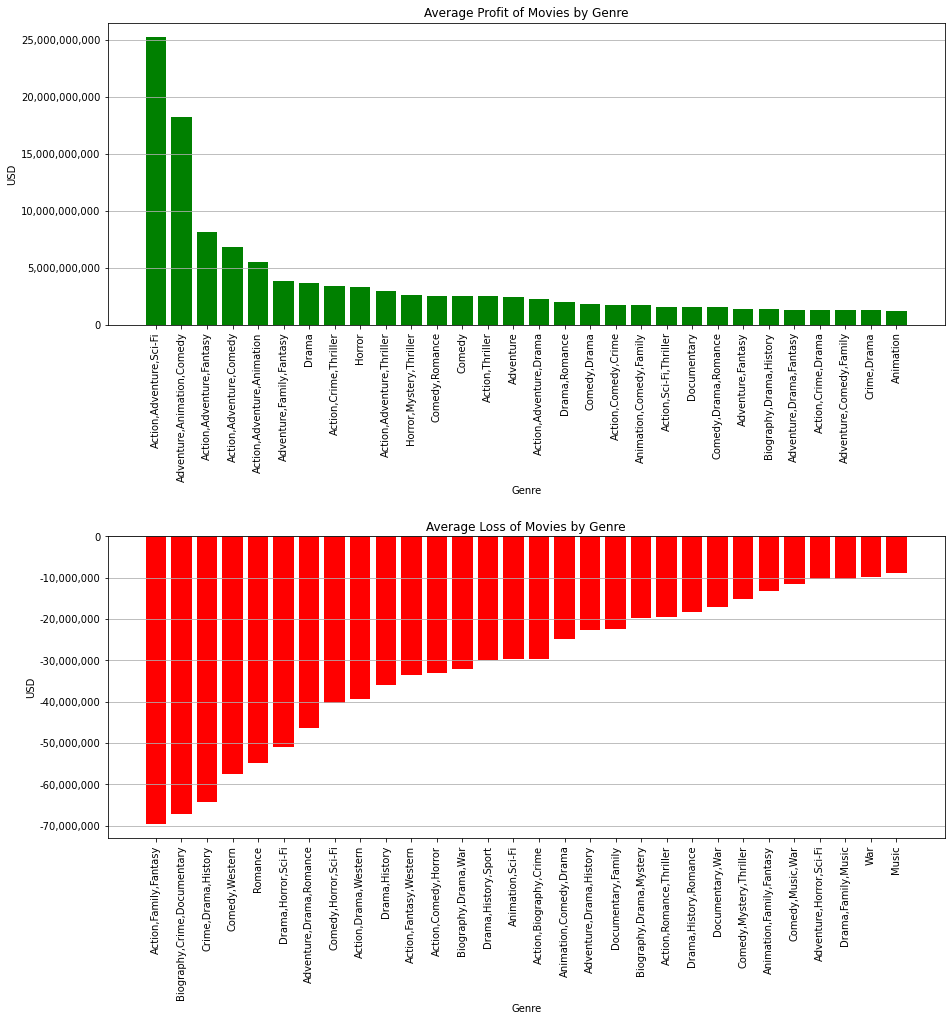

In [1364]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,15), nrows=2, ncols=1)

ax1.bar(genre_gross_top.Genres, genre_gross_top.profit_or_loss, color="g")

ax1.set_title("Average Profit of Movies by Genre")

plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.ticklabel_format(style="plain", axis="y")
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.set_xlabel("Genre")
ax1.set_ylabel("USD")
ax1.grid(axis="y")

#######

ax2.bar(genre_gross_bottom.Genres, genre_gross_bottom.profit_or_loss, color="r")
ax2.set_title("Average Loss of Movies by Genre")

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.ticklabel_format(style="plain", axis="y")
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel("Genre")
ax2.set_ylabel("USD")
ax2.grid(axis="y")

#######

plt.subplots_adjust(hspace=0.7)
plt.show()

We can also have a visual comparison of the earnings with the budget.

In [1371]:
wwg_top = genre_gross_top.sort_values(by="worldwide_gross", ascending=False)
wwg_bottom = genre_gross_bottom.sort_values(by="worldwide_gross", ascending=False)

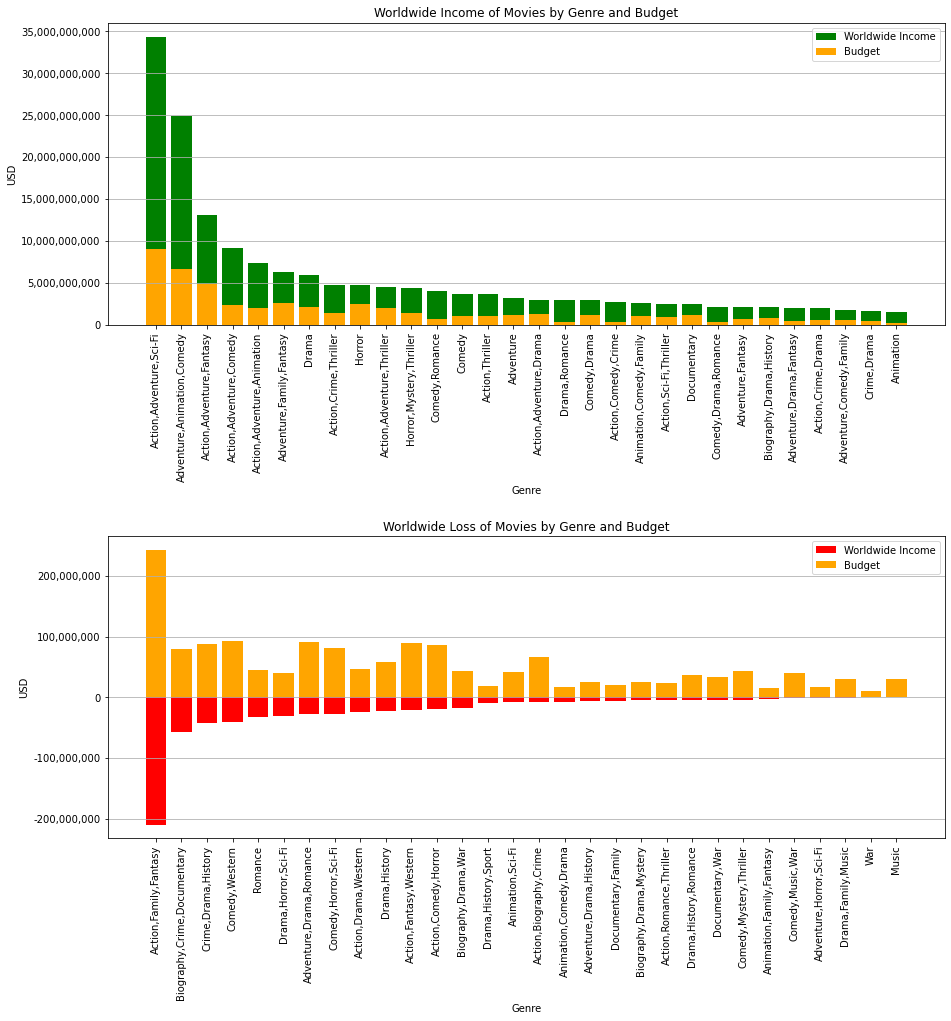

In [1374]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,15), nrows=2, ncols=1)

ax1.bar(genre_gross_top.Genres, wwg_top.worldwide_gross, color="g")
ax1.bar(genre_gross_top.Genres, wwg_top.production_budget, color="orange")

ax1.set_title("Worldwide Income of Movies by Genre and Budget")


plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.ticklabel_format(style="plain", axis="y")
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.set_xlabel("Genre")
ax1.set_ylabel("USD")
ax1.legend(labels=['Worldwide Income', 'Budget'])
ax1.grid(axis="y")

#######

ax2.bar(genre_gross_bottom.Genres, -wwg_bottom.worldwide_gross, color="r")
ax2.bar(genre_gross_bottom.Genres, wwg_bottom.production_budget, color="orange")

ax2.set_title("Worldwide Loss of Movies by Genre and Budget")

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.ticklabel_format(style="plain", axis="y")
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel("Genre")
ax2.set_ylabel("USD")
ax2.legend(labels=['Worldwide Income', 'Budget'])
ax2.grid(axis="y")

#######
plt.subplots_adjust(hspace=0.7)
plt.show()

It would be convenient to also do an analysis based on the relationship between the budget and the revenue; because, as we can see in the previous tables, some movies barely earn or loss the production budgets amount than others which may have even surpass it.

In [1378]:
relation_top = genre_gross_top.sort_values(by="relation_pro_los", ascending=False)
relation_bottom = genre_gross_bottom.sort_values(by="relation_pro_los", ascending=False)

We plot again.

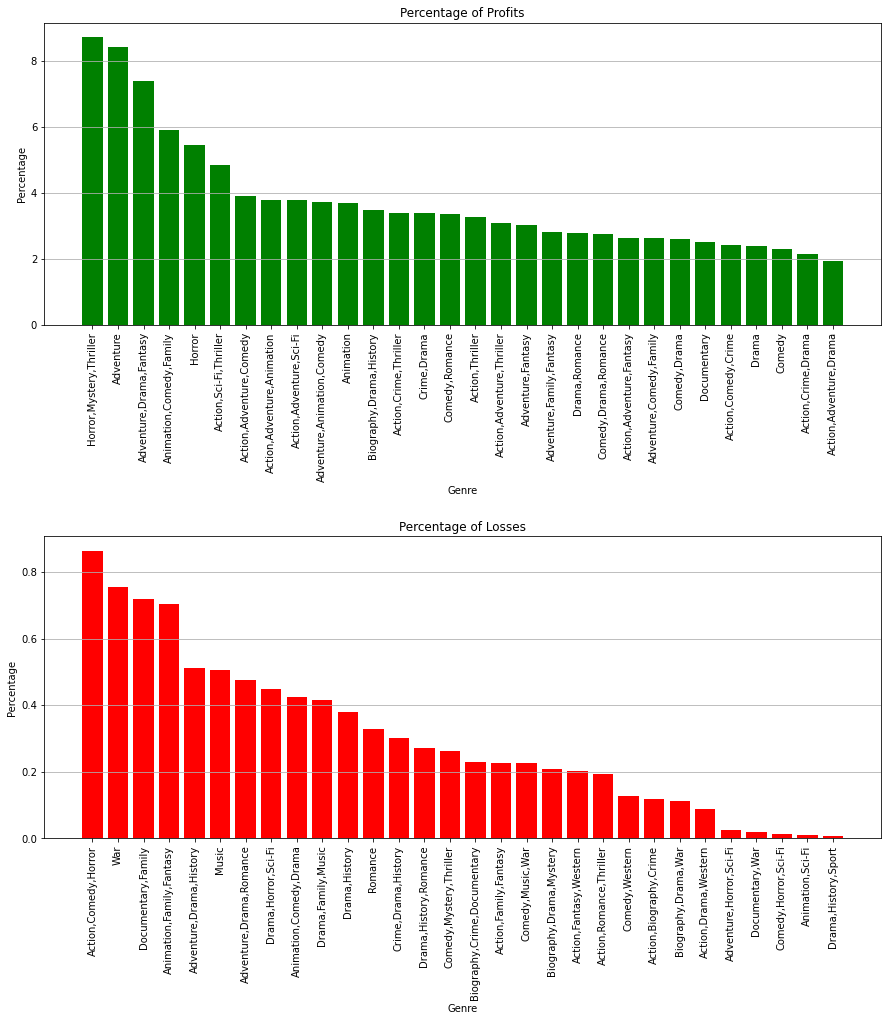

In [1379]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,15), nrows=2, ncols=1)

ax1.bar(relation_top.Genres, relation_top.relation_pro_los, color="g")

ax1.set_title("Percentage of Profits")

plt.draw()
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax1.set_xlabel("Genre")
ax1.set_ylabel("Percentage")
ax1.grid(axis="y")

#######

ax2.bar(relation_bottom.Genres, relation_bottom.relation_pro_los, color="r")
ax2.set_title("Percentage of Losses")

plt.draw()
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

ax2.set_xlabel("Genre")
ax2.set_ylabel("Percentage")
ax2.grid(axis="y")

#######

plt.subplots_adjust(hspace=0.7)
plt.show()

As we can see, even if the plots are somewhat similar, they have key differences that may be relevant for later analysis.

## Statistical Analysis

Now that we have got a bunch of information from visualization, it is time to be certain of what we are proposing, and for that matter we ougth to perform a statistical analysis which will let us know if our results are significant or not.

We got to now basic statistic values to start with, this is the mean, median, standard deviation and some more, from both the population and our sample, which we decided to be 30 for this case.

In [1355]:
genre_gross_grouped.describe()

,production_budget,domestic_gross,worldwide_gross,profit_or_loss,relation_pro_los
count,2.810000e+02,2.810000e+02,2.810000e+02,2.810000e+02,281.000000
mean,2.804280e+08,3.498363e+08,8.555138e+08,5.750858e+08,2.679059
std,8.105352e+08,1.047753e+09,2.837679e+09,2.049457e+09,2.610660
min,1.750000e+05,0.000000e+00,0.000000e+00,-9.000000e+07,0.000000
25%,2.590800e+07,1.811593e+07,3.019910e+07,2.714573e+06,1.079408
50%,7.810000e+07,7.604915e+07,1.569076e+08,7.471642e+07,2.224965
75%,2.095500e+08,2.839318e+08,6.153458e+08,4.099110e+08,3.393930
max,9.070400e+09,1.258900e+10,3.429490e+10,2.522450e+10,19.534452


In [1356]:
genre_gross_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 0 to 280
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Genres             281 non-null    object 
 1   production_budget  281 non-null    float64
 2   domestic_gross     281 non-null    float64
 3   worldwide_gross    281 non-null    float64
 4   profit_or_loss     281 non-null    float64
 5   relation_pro_los   281 non-null    float64
dtypes: float64(5), object(1)
memory usage: 15.4+ KB
